In [1]:
import math
from torch import nn, Tensor
import torch
import matplotlib.pyplot as plt

In [2]:
# https://github.com/Blealtan/efficient-kan/blob/master/src/efficient_kan/kan.py

import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [3]:
vocab = ['a','b','c']

words = []
for i in vocab:
  for j in vocab:
    for k in vocab:
      words.append(i+j+k)


print('words',words)
vocab.append('0')
print('vocab',vocab)

letter_to_index = {letter: index for index, letter in enumerate(vocab)}
index_to_letter = {index: letter for index, letter in enumerate(vocab)}

word_to_index = {word: index for index, word in enumerate(words)}
index_to_word = {index: word for index, word in enumerate(words)}



#print(letter_to_index)
#print(index_to_letter)

#print(word_to_index)
#print(index_to_word)

N = len(words)
# includes special end of word character
V = len(vocab)
# includes end of word character
L = max(len(word) for word in words)+1

print('# of words',N)
print('# of chars',V)
print('seq len', L)

words ['aaa', 'aab', 'aac', 'aba', 'abb', 'abc', 'aca', 'acb', 'acc', 'baa', 'bab', 'bac', 'bba', 'bbb', 'bbc', 'bca', 'bcb', 'bcc', 'caa', 'cab', 'cac', 'cba', 'cbb', 'cbc', 'cca', 'ccb', 'ccc']
vocab ['a', 'b', 'c', '0']
# of words 27
# of chars 4
seq len 4


In [4]:
# Define the dimensions
# Prepare training set
X_train = []
Y_train = []

for word in words:

    chars = list(word)
    x = torch.zeros(1, L, N)
    y = torch.zeros(1, L)

    n = len(chars)
    for i in range(L):
        x[0, i, word_to_index[word]] = 1
        if i < n:
            y[0,i] = letter_to_index[chars[i]]
        else:
            y[0,i] = V-1

    X_train.append(x)
    Y_train.append(y)

# Convert the training set to tensors
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

# Print the shape of the training set
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
# prepare training set



X_train shape: torch.Size([27, 4, 27])
Y_train shape: torch.Size([27, 4])


In [5]:
# https://github.com/KasperGroesLudvigsen/influenza_transformer/blob/main/positional_encoder.py

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        layers = []
        prev_size = input_size
        for size in hidden_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            prev_size = size
        layers.append(nn.Linear(prev_size, output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what
    the positional encoding layer does and why it is needed:

    "Since our model contains no recurrence and no convolution, in order for the
    model to make use of the order of the sequence, we must inject some
    information about the relative or absolute position of the tokens in the
    sequence." (Vaswani et al, 2017)
    Adapted from:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self,
        dropout: float=0.1,
        max_seq_len: int=100,
        d_model: int=512,
        batch_first: bool=True
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model

        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        # adapted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)


        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))


        if self.batch_first:

            pe = torch.zeros(1, max_seq_len, d_model)

            pe[0, :, 0::2] = torch.sin(position * div_term)

            pe[0, :, 1::2] = torch.cos(position * div_term)[:,:(d_model//2)]


        else:
            pe = torch.zeros(max_seq_len, 1, d_model)

            pe[:, 0, 0::2] = torch.sin(position * div_term)

            pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or
               [enc_seq_len, batch_size, dim_val]
        """
        if self.batch_first:
            x = x + self.pe[:,:x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)

class myRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, max_seq_len=L, MLP_hidden_sizes=[10,10], head='MLP'):
        super(myRNN, self).__init__()
        self.input_size = input_size
        self.pos_encoder = PositionalEncoder(d_model = input_size, dropout=0.1, max_seq_len=max_seq_len)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers,batch_first=True)
        self.head = nn.Linear(hidden_size, num_classes)

        if head == 'MLP':
          self.head = MLP(hidden_size, MLP_hidden_sizes, num_classes)
        elif head == 'KAN':
          self.head = KAN([hidden_size]+MLP_hidden_sizes+[num_classes])
        else:
          pass





    def forward(self, x):
        # Initialize hidden state with zeros
        # h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        #h0 can be improved (h0 = x*toen_embedding)

        # Forward pass through RNN
        #out, _ = self.rnn(x, h0)
        x = x * math.sqrt(self.input_size)
        x = self.pos_encoder(x)
        out, _ = self.rnn(x)

        # Concatenate the output of RNN with y
        #out = torch.cat((out[:, -1, :], y.unsqueeze(1)), dim=1)
        # out = out[:, -1, :]

        # Pass the concatenated output through the fully connected layer

        shape = out.shape
        out = out.reshape(shape[0]*shape[1],shape[2])
        out = self.head(out)

        return out

In [6]:
# Train the model
def trainer(X_train, Y_train,batch_size, model):
  loss_acc = []
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(num_epochs):
      # Shuffle the training data
      indices = torch.randperm(X_train.size(0))
      X_train_shuffled = X_train[indices]
      Y_train_shuffled = Y_train[indices]

      # Split the training data into batches
      num_batches = X_train.size(0) // batch_size
      for batch_idx in range(num_batches):
          # Get the batch inputs and targets
          start_idx = batch_idx * batch_size
          end_idx = start_idx + batch_size
          batch_inputs = X_train_shuffled[start_idx:end_idx]
          batch_targets = Y_train_shuffled[start_idx:end_idx]

          # Forward pass
          outputs = model(batch_inputs)
          shape = outputs.shape
          outputs = outputs.reshape(shape[0]//L,L,shape[1])

          # Compute the loss
          loss = criterion(outputs.view(-1, num_classes), batch_targets.view(-1).long())

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      # Print the loss for this epoch
      #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
      loss_acc.append(loss.item())
  return loss_acc, model

def Detokenise(X, model):
  with torch.no_grad():
    outputs = model(X)
    shape = outputs.shape
    outputs = outputs.reshape(shape[0]//L,L,shape[1])
  predicted_words = []

  for output in outputs:
    predicted_word = ''
    for i in range(L):
      index = torch.argmax(output[i])
      if index == V-1:
        break
      predicted_word += index_to_letter[index.item()]
    predicted_words.append(predicted_word)
  return predicted_words

def getAcc(test_word_ids, predicted_words):
  acc = 0
  for i in range(len(test_word_ids)):
    w = words[test_word_ids[i]]
    wh = predicted_words[i]
    acc += w==wh
    print(w,wh, w==wh)
  return 100*acc/N

In [7]:
input_size = N
hidden_size = 5*V
num_classes = V
num_layers = 3
num_epochs = 1000
batch_size = 15
MLP_hidden_sizes = [5*V,5*V]
lr = 0.001

myRNN(
  (pos_encoder): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (rnn): RNN(27, 20, num_layers=3, batch_first=True)
  (head): MLP(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=4, bias=True)
    )
  )
)
aaa aaa True
aab aab True
aac aac True
aba aba True
abb abb True
abc abc True
aca aca True
acb acb True
acc acc True
baa baa True
bab bab True
bac bac True
bba bba True
bbb bbb True
bbc bbc True
bca bca True
bcb bcb True
bcc bcc True
caa caa True
cab cab True
cac cac True
cba cba True
cbb cbb True
cbc cbc True
cca cca True
ccb ccb True
ccc ccc True
acc is 100.0


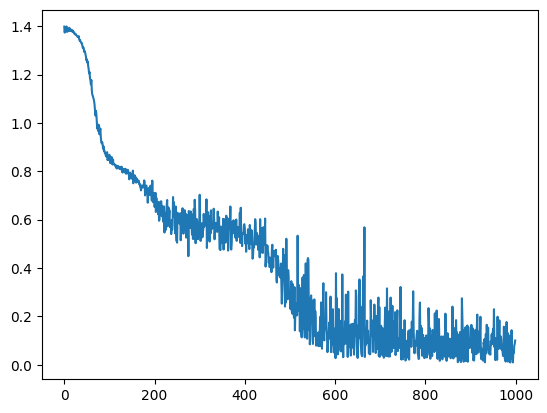

In [8]:
# Create an instance of the RNN model
model = myRNN(input_size, hidden_size, num_classes, num_layers=num_layers, max_seq_len=L,MLP_hidden_sizes=MLP_hidden_sizes, head='MLP')
print(model)

loss_acc_mlp, model = trainer(X_train, Y_train, batch_size, model)
plt.plot(loss_acc_mlp)

test_word_ids= list(range(0, N))
X_test = X_train[test_word_ids]

model.eval()

predicted_words = Detokenise(X_test,model)
acc = getAcc(test_word_ids, predicted_words)
print('acc is',acc)

myRNN(
  (pos_encoder): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (rnn): RNN(27, 20, num_layers=3, batch_first=True)
  (head): KAN(
    (layers): ModuleList(
      (0-2): 3 x KANLinear(
        (base_activation): SiLU()
      )
    )
  )
)
aaa aaa True
aab aab True
aac aac True
aba aba True
abb abb True
abc abc True
aca aca True
acb acb True
acc acc True
baa baa True
bab bab True
bac bac True
bba bba True
bbb bbb True
bbc bbc True
bca bca True
bcb bcb True
bcc bcc True
caa caa True
cab cab True
cac cac True
cba cba True
cbb cbb True
cbc cbc True
cca cca True
ccb ccb True
ccc ccc True
acc is 100.0


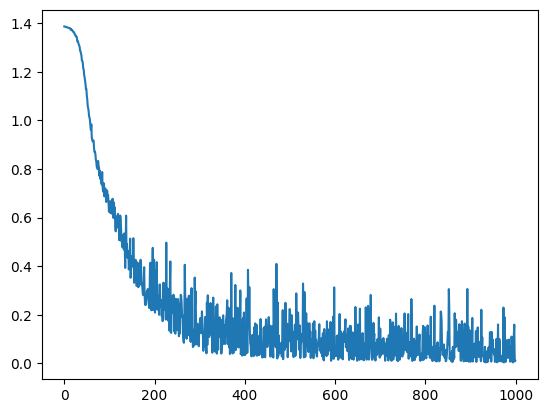

In [9]:
# Create an instance of the RNN model
kan = myRNN(input_size, hidden_size, num_classes, num_layers=num_layers, max_seq_len=L,MLP_hidden_sizes=MLP_hidden_sizes, head='KAN')
print(kan)

loss_acc_kan, kan = trainer(X_train, Y_train, batch_size, kan)
plt.plot(loss_acc_kan)

test_word_ids= list(range(0, N))
X_test = X_train[test_word_ids]

kan.eval()

predicted_words = Detokenise(X_test,kan)
acc = getAcc(test_word_ids, predicted_words)
print('acc is',acc)

Text(0, 0.5, 'loss')

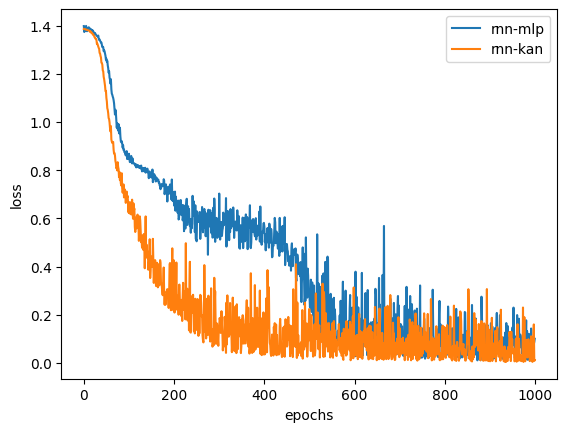

In [13]:
plt.plot(loss_acc_mlp,label='rnn-mlp')
plt.plot(loss_acc_kan,label='rnn-kan')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')